### Source code for OU ECE-5583: Information Theory and Probabilistic Programming

[course website](https://samuelcheng.us/information_theory_2023/index.html), [video](https://mymedia.ou.edu/media/IT2023+-+Lecture+4+/1_eercerh7)

# Central limit theorem
As independent variables added together, the sum becomes more and more like Gaussian

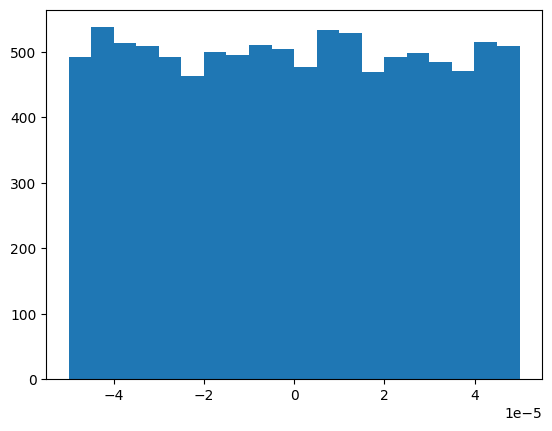

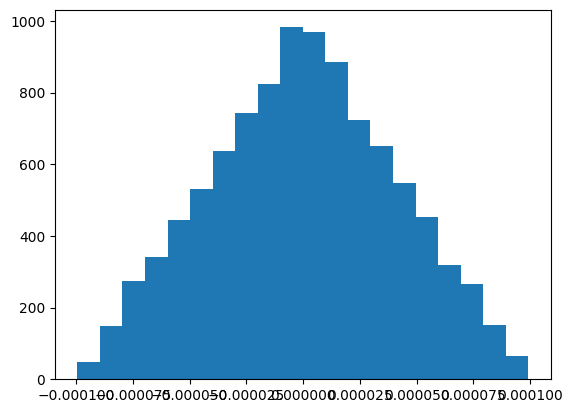

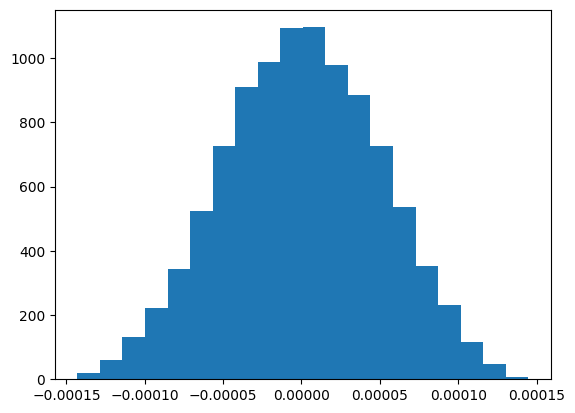

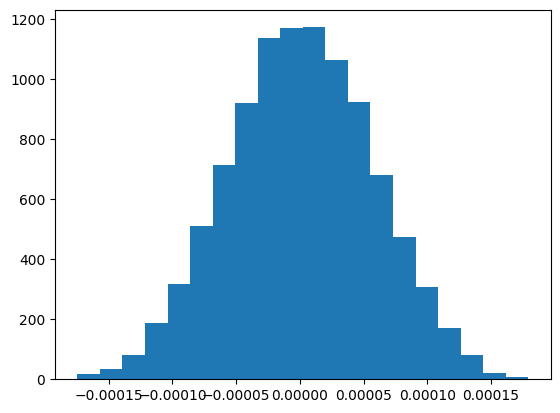

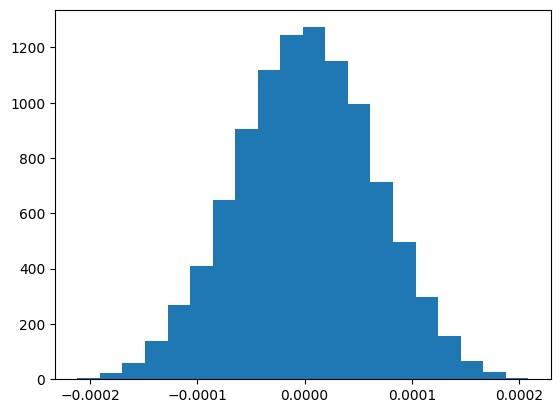

In [27]:
import numpy as np
from matplotlib import pyplot as plt
import time

N=10000
delta = 0.0001
x=np.zeros(N)
for i in range(5):
    x+=delta*(np.random.rand(N)-0.5)
#     x+=delta*np.sign(np.random.rand(N)-0.5)
    plt.hist(x,bins=20)
    
    if i % 1 ==0:
        plt.show()
#     time.sleep(1)

# Sample multivariate Gaussian with covariance matrix $\begin{pmatrix}a & b\\ b& c \end{pmatrix}$

In [22]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact


def plot_gaussian(a=1,b=0.5,c=1):
    mean = [0, 0]  # Mean vector
    cov = [[a, b], [b, c]]  # Covariance matrix

    # Generate samples

    samples = np.random.multivariate_normal(mean, cov, 1000)
    evalues,evectors=np.linalg.eig(cov)
    if evalues[0] <0 or evalues[1] < 0:
        return    plt.figure(figsize=(7,7))
    plt.plot(samples.T[0],samples.T[1],'.')
    plt.plot([0,evalues[0]*evectors[0][0]],[0,evalues[0]*evectors[1][0]],'r')
#     plt.arrow(0,0, evalues[0]*evectors[0][0],evalues[0]*evectors[1][0],head_length=1,fc='r',ec='r')
    
    plt.plot([0,evalues[1]*evectors[0][1]],[0,evalues[1]*evectors[1][1]],'r')
#     plt.ylim(-1.1, 1.1)
    plt.title(f'Eigenvalues {evalues}')
    plt.axis('equal')
    plt.show()
    
interact(plot_gaussian, a=(0.1,5,0.1), b=(-5,5,0.1), c=(0.1, 5.0, 0.1))
    

interactive(children=(FloatSlider(value=1.0, description='a', max=5.0, min=0.1), FloatSlider(value=0.5, descri…

<function __main__.plot_gaussian(a=1, b=0.5, c=1)>

# Contour plot of $\mathcal{N}\left(x;0,\begin{pmatrix}a & b\\ b& c \end{pmatrix}\right)$

In [23]:
x, y = np.linspace(-5, 5, 100), np.linspace(-5, 5, 100)
x, y = np.meshgrid(x, y)

def gaussian_2d(x, y, mu, cov):
    X = np.stack((x, y), axis=-1)  # Create a 2D point from x and y
    diff = X - mu  # Difference from the mean
    inv_cov = np.linalg.inv(cov)  # Inverse of the covariance matrix
    exponent = -0.5 * np.einsum('...k,kl,...l->...', diff, inv_cov, diff)  # Exponential term
    return np.exp(exponent) / (2 * np.pi * np.sqrt(np.linalg.det(cov)))  # The Gaussian PDF


def plot_gaussian_pdf(a=1,b=0.5,c=1):
    mu = np.array([0.0, 0.0])
    cov = np.array([[a, b], [b, c]])

    z = gaussian_2d(x, y, mu, cov)

    plt.figure(figsize=(8, 8))
    evalues,evectors=np.linalg.eig(cov)
    
    if evalues[0] <0 or evalues[1] < 0:
        return

    # Contour plot
    contour = plt.contour(x, y, z, levels=50, colors='black')
    plt.clabel(contour, inline=1, fontsize=10)

    # Filled contour plot
    plt.contourf(x, y, z, levels=50, cmap="viridis")
    plt.plot([0,evalues[0]*evectors[0][0]],[0,evalues[0]*evectors[1][0]],'r')
#     plt.arrow(0,0, evalues[0]*evectors[0][0],evalues[0]*evectors[1][0],head_length=1,fc='r',ec='r')
    
    plt.plot([0,evalues[1]*evectors[0][1]],[0,evalues[1]*evectors[1][1]],'r')

    plt.colorbar(label="PDF Value")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')

    plt.title(f'Eigenvalues {evalues}')
    
#     plt.title("Contour Plot of 2D Gaussian PDF")
    plt.show()

interact(plot_gaussian_pdf, a=(0.1,5,0.1), b=(-5,5,0.1), c=(0.1, 5.0, 0.1))

interactive(children=(FloatSlider(value=1.0, description='a', max=5.0, min=0.1), FloatSlider(value=0.5, descri…

<function __main__.plot_gaussian_pdf(a=1, b=0.5, c=1)>

# Gaussian process
## Interpolating 1-D sinusoidal signal with missing data

In [1]:
import numpy as np
import random

# return conditioned mean and variances given observation
def return_posterior(mean,observed,cov,mask):
    if len(mask)!=len(mean):
        print('mask should have same length as mean')
        print('not observe at mask=0')
        return None
    if len(cov.shape)!=2:
        print('cov should be a matrix')
        return None
    if cov.shape[0]!=len(mean) and cov.shape[1]!=len(mean):
        print('covariance dimension not right')
        return None
    if len(observed)!=len(mean):
        print('observed is expected to have same size as mean (please pad it)')
        return None
    

    xinds=np.where(mask==0)[0]
    yinds=np.where(mask!=0)[0]

    cov_yy=cov[np.ix_(yinds,yinds)]
    cov_xy=cov[np.ix_(xinds,yinds)]
    cov_yx=cov[np.ix_(yinds,xinds)]
    cov_xx=cov[np.ix_(xinds,xinds)]

    mx=mean[xinds]
    my=mean[yinds]

    obs=observed[yinds]
    nm=observed.copy()
    nm[xinds]=mx+cov_xy @ np.linalg.inv(cov_yy)@(obs-my)

    tcov = cov_xx - cov_xy @ np.linalg.inv(cov_yy) @cov_yx
    ncov=cov
    ncov[np.ix_(xinds,xinds)]=tcov    

    var=np.diag(ncov).copy()
    var[yinds]=0
    std=np.sqrt(var)

    return nm,std



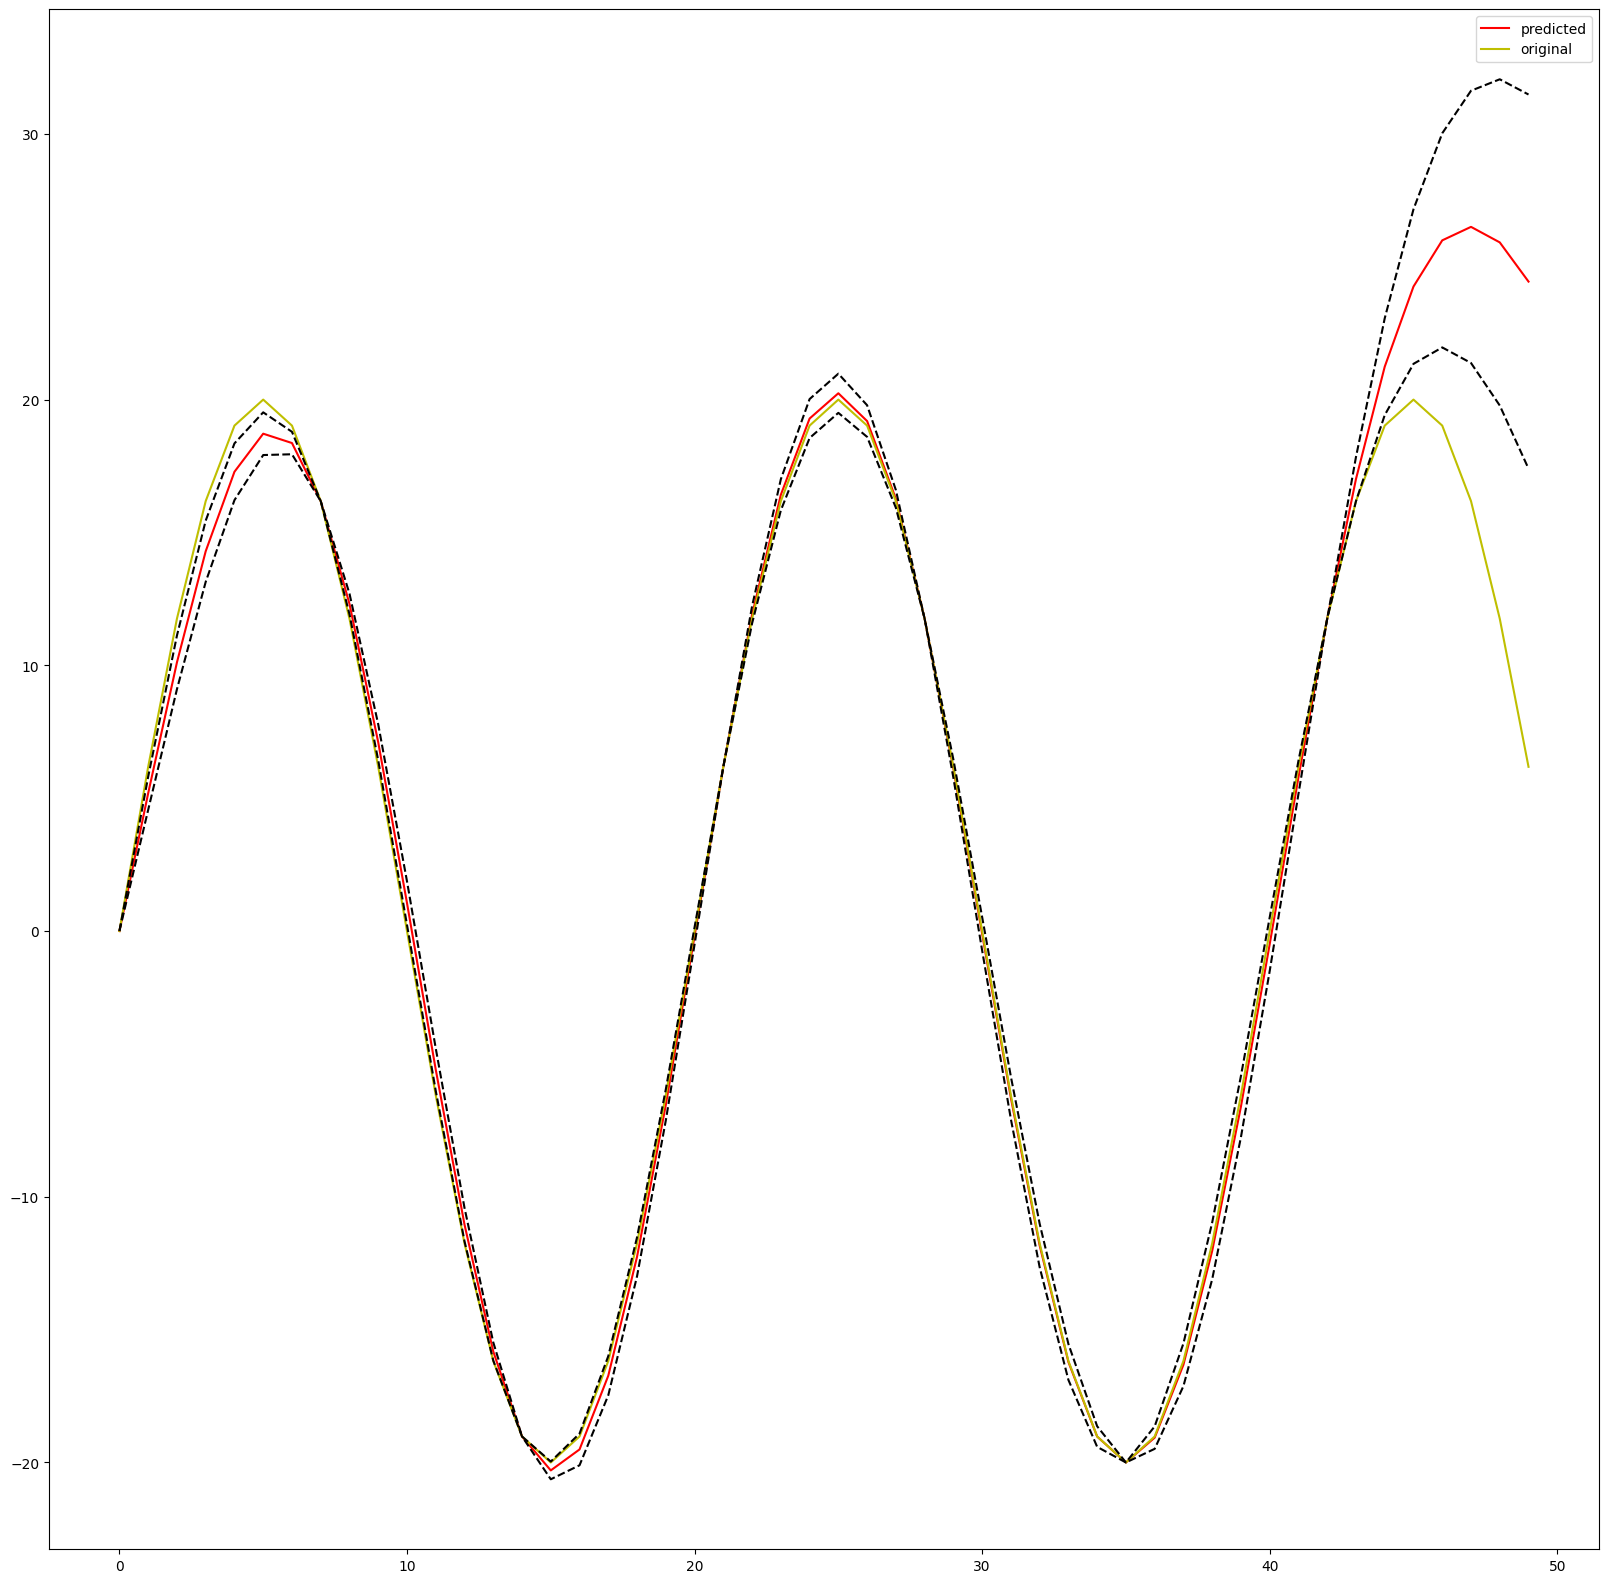

In [2]:
from matplotlib import pyplot as plt
import numpy as np
observed=20*np.sin(2*np.pi*np.array(range(50))/20);
# plt.plot(observed)

N=len(observed)
rho=0.99
cov=np.zeros((N,N))
for i in range(1,N): # square exponential is better than OU in this case
#     cov=cov+rho**(i)*np.diag(np.ones(N-i),i)+rho**(i)*np.diag(np.ones(N-i),-i) # OU
    cov=cov+rho**(i**2)*np.diag(np.ones(N-i),i)+rho**(i**2)*np.diag(np.ones(N-i),-i)
cov=cov+np.diag(np.ones(N));
cov=cov*100
mean=np.zeros(N)

mask=np.zeros(N)
gap=7
for i in range(int(N/gap)):
    mask[gap*i]=1

nm,std = return_posterior(mean,observed,cov,mask)

plt.figure(figsize=(20,20))
plt.plot(nm,'r')
plt.plot(observed,'y')
plt.plot(nm+std,'k--')
plt.plot(nm-std,'k--')
plt.legend(['predicted','original'])

## interpolating random walk data

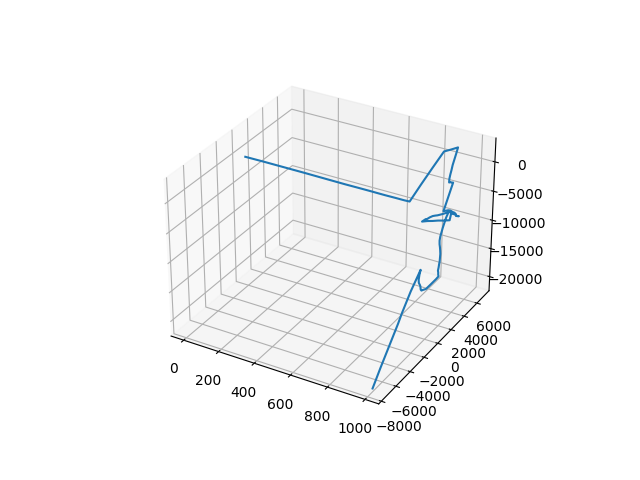

In [3]:
from gaussian import *
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

def my_walk(acc_mean,acc_var,vel_mean,vel_var,p_change,scale=lambda loc:1,steps=1000,start_loc=(0,0)):
# p_change: probability of change velocity completely (sample from vel_mean, vel_var)
    vel = np.zeros(2)

    locs=[]
    loc=np.array(start_loc).astype(float)
    # locs.append(loc)
    for s in range(steps):
        if random.random() < p_change: # new velocity
            vel = np.random.normal(vel_mean,np.sqrt(vel_var),2)
        else: 
            vel += np.random.normal(acc_mean,np.sqrt(acc_var),2)
        loc += vel * scale(loc)
        # print(loc)
        locs.append(loc.copy())

    # print(locs)
    return locs

scale_fcn = lambda loc: 0.05 if np.abs(loc[0])+np.abs(loc[1])<50 else 100
locs=my_walk((0,0),(0.5,0.5),(0,0),(25,25),0.1,scale_fcn)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


locs=np.array(locs).reshape(-1,2)
ax.plot(range(locs.shape[0]),locs[:,0],locs[:,1])

In [4]:
L = locs.shape[0]
all_mask = np.zeros(L)
n_locs_mean = np.zeros((L,2))
n_locs_std = np.zeros((L,2))

gap=10 # sample every "gap" 
for i in range(int(L/gap)):
    all_mask[i*gap]=1

In [5]:
batchsize=100
D=100

i=0
for b in range(int(L/batchsize)):
# b=1
    inds=range(max([b*batchsize-D,0]), min(L,(b+1)*batchsize+D))
    N=len(inds)

    rho=0.99999995
    cov=np.zeros((N,N))
    # OU seems better in this case (not confirmed tho, highly depends on rho)
    for i in range(1,N):
        cov=cov+rho**(i)*np.diag(np.ones(N-i),i)+rho**(i)*np.diag(np.ones(N-i),-i) # OU
#         cov=cov+rho**(i**2)*np.diag(np.ones(N-i),i)+rho**(i**2)*np.diag(np.ones(N-i),-i) # square exponential
    cov=cov+np.diag(np.ones(N));
    cov=cov*100
    mean=np.zeros(N)
    mask=all_mask[inds]

    # nm,std = return_posterior(mean,locs[inds,0],cov,mask)
    # n_locs_mean[inds,0]=nm
    # n_locs_std[inds,0]=std

    observed=locs[inds,0] # just make sure
    observed[np.where(mask==0)]=0
    n_locs_mean[inds,0],n_locs_std[inds,0] = return_posterior(mean,observed,cov,mask)
    n_locs_mean[inds,1],n_locs_std[inds,1] = return_posterior(mean,locs[inds,1],cov,mask)
    print(b)

/home/phsamuel/Dropbox (Univ. of Oklahoma)/courses/mine/IT/code/gaussian/gaussian.py:41: RuntimeWarning: invalid value encountered in sqrt
  std=np.sqrt(var)


0
1
2
3
4
5
6
7
8
9


mse: 593290.7314341848


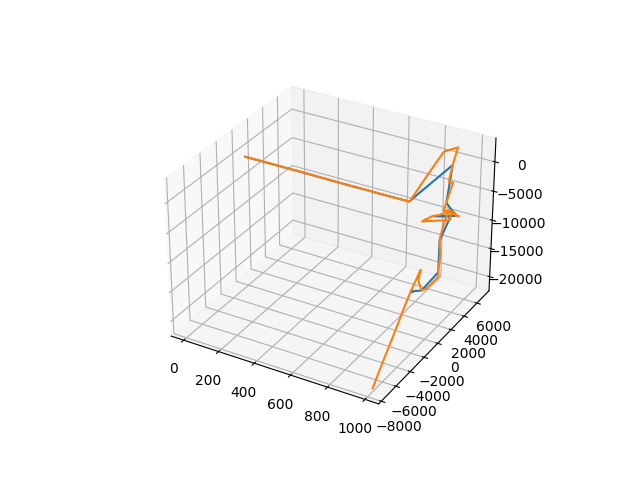

In [8]:
# plot results

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# locs=np.array(locs).reshape(-1,2)
ax.plot(range(locs.shape[0]),n_locs_mean[:,0],n_locs_mean[:,1])
ax.plot(range(locs.shape[0]),locs[:,0],locs[:,1])
print(f'mse: {np.sum((n_locs_mean-locs)**2)/L}')